In [88]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
df = pd.read_csv('../data/raw/ecommerceDataset.csv', names=['category', 'text'])

**Первичный анализ данных**

In [90]:
df.head()

,category,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  50425 non-null  object
 1   text      50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [92]:
df['category'].unique()

array(['Household', 'Books', 'Clothing & Accessories', 'Electronics'],
      dtype=object)

In [93]:
df.shape

(50425, 2)

In [94]:
df.isna().sum()

category    0
text        1
dtype: int64

Проведя первичный анализ видно, что в данных имеется 50425 строк и 4 различные категории
Также присутствует 1 пропуск в столбце "text"

In [95]:
df[df['text'].isna()]

,category,text
39330,Clothing & Accessories,NaN


Проверка дисбаланса классов для определения итоговой метрики

In [96]:
df['category'].value_counts(normalize=True) * 100

category
Household                 38.300446
Books                     23.440754
Electronics               21.062965
Clothing & Accessories    17.195835
Name: proportion, dtype: float64

In [97]:
df['category'].value_counts()

category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64

В категории "Clothing & Accessories" присутсвует 17% записей из всех данных, исходя из этого, можно сделать вывод, что в классах присутствует дисбаланс, но умеренный.

Метрика Accuracy будет отдавать предпочтение классу "Household" из-за превосходящего количества записей в нем.

Использовать F1_score (macro) будет наиболее правильным решением, потому что нам необходимо одинаково учитывать качество классификации.


**Подготовка данных**

Удалим одну строку, где отсутвует значение, а также оставим только те записи, где длина текста больше 10.

Такие записи не содержат достаточного семантического контекста для уверенной классификации.

In [98]:
df = df[df['text'].str.len() > 10]

In [99]:
df = df.dropna()

**Построение графиков для наглядного представления содержания информации данных**

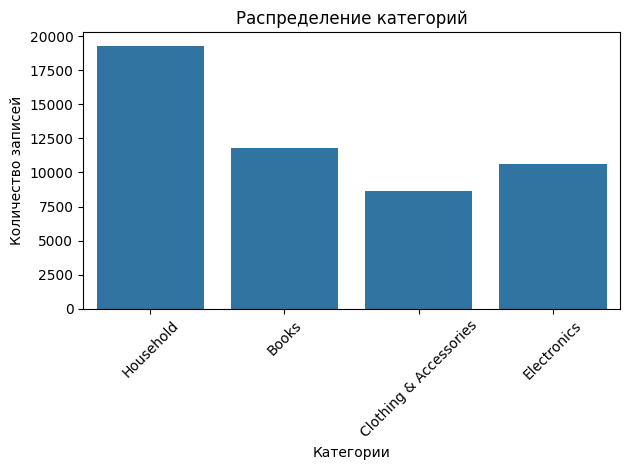

In [100]:
sns.countplot(data=df, x='category')
plt.xticks(rotation=45)
plt.title('Распределение категорий')
plt.xlabel('Категории')
plt.ylabel('Количество записей')
plt.tight_layout()

Статистика длины текста:
count    50381.000000
mean       714.715071
std        973.571094
min         11.000000
50%        488.000000
75%        954.000000
90%       1557.000000
95%       1940.000000
max      50403.000000
Name: len_text, dtype: float64


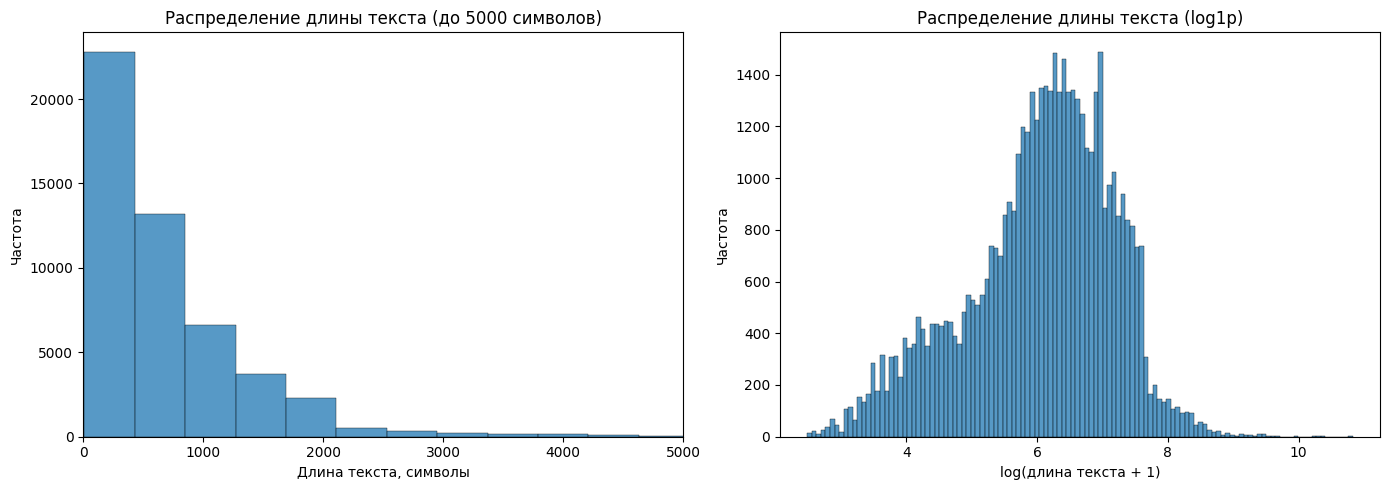

In [101]:
# Распределение длины текста
if 'len_text' not in df.columns:
    df['len_text'] = df['text'].str.len()

length_stats = df['len_text'].describe(percentiles=[0.5, 0.75, 0.9, 0.95])
print("Статистика длины текста:")
print(length_stats)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Распределение с обрезкой до 5000
sns.histplot(df['len_text'], bins=120, ax=axes[0])
axes[0].set_title('Распределение длины текста (до 5000 символов)')
axes[0].set_xlim(0, 5000)
axes[0].set_xlabel('Длина текста, символы')
axes[0].set_ylabel('Частота')

# Лог-шкала для длинных текстов
sns.histplot(np.log1p(df['len_text']), bins=120, ax=axes[1])
axes[1].set_title('Распределение длины текста (log1p)')
axes[1].set_xlabel('log(длина текста + 1)')
axes[1].set_ylabel('Частота')

plt.tight_layout()

In [102]:
df.groupby('category')['len_text'].describe(percentiles=[0.5, 0.75, 0.9, 0.95])

,count,mean,std,min,50%,75%,90%,95%,max
category,,,,,,,,,
Books,11780.0,859.890662,1626.800428,11.0,499.0,1065.0,1994.0,2842.30,50403.0
Clothing & Accessories,8669.0,446.352174,393.453364,14.0,342.0,568.0,984.0,1286.20,3474.0
Electronics,10620.0,851.186817,813.679238,24.0,630.5,1222.0,1768.0,2018.05,12473.0
Household,19312.0,671.578138,606.379518,16.0,515.0,903.0,1392.0,1737.00,10168.0


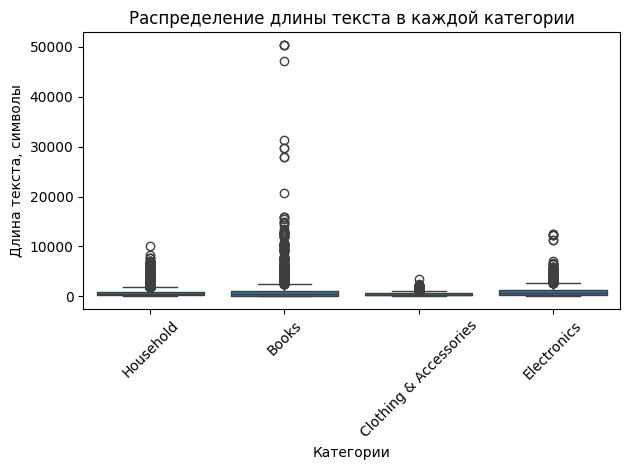

In [103]:
sns.boxplot(data=df, x='category', y='len_text')
plt.xticks(rotation=45)
plt.title('Распределение длины текста в каждой категории')
plt.xlabel('Категории')
plt.ylabel('Длина текста, символы')
plt.tight_layout()

- Распределение длины текстов имеет ярко выраженный правый хвост
- Большинство описаний укладывается в диапазон примерно 200–1000 символов
- 95% текстов короче 2000 символов, но присутствует небольшое число очень длинных описаний в несколько тысяч символов, которые можно считать выбросами и учитывать отдельно при подготовке данных для модели.

## Выводы на основе проведенного EDA анализа

### 1. Общая характеристика датасета

**Размерность и структура:**
- Датасет содержит **50,425 записей** текстовых описаний товаров
- Структура данных простая: 2 столбца - категория и текст
- Данные представлены в виде текстовых описаний товаров из интернет-магазина

**Качество данных:**
- **Минимальное количество пропусков**: всего 1 пропуск в столбце "text"
- **Высокое качество данных**: после удаления пропусков и фильтрации коротких текстов остается ~50,381 записей
- Данные готовы к использованию в машинном обучении без серьезной предобработки

### 2. Анализ целевой переменной (категорий)

**Распределение категорий:**
- Датасет содержит **4 категории товаров**:
  - **Household** (~38%) - наибольшая категория
  - **Books** (~23%)
  - **Electronics** (~21%)
  - **Clothing & Accessories** (~17%) - наименьшая категория

**Дисбаланс классов:**
- **Умеренный дисбаланс классов**: соотношение между самой большой и самой маленькой категорией составляет примерно 2:1
- Это не критичный дисбаланс, но требует внимания при выборе метрик и стратегии обучения модели
- Рекомендуется использовать метрики, учитывающие дисбаланс (F1-score macro, precision/recall по классам)

### 3. Анализ текстовых данных

**Длина текстов:**
- 📏 **Медианная длина текста**: ~488 символов
- 📏 **75% текстов** имеют длину менее 954 символов
- 📏 **90% текстов** имеют длину менее 1557 символов
- 📏 Основная масса текстов находится в диапазоне **200-1000 символов**

**Распределение по категориям:**
- Категория **"Books"** имеет наибольшее количество выбросов по длине текста
- Различные категории демонстрируют различия в распределении длины текстов
- Это может быть полезной информацией для модели классификации

**Особенности текстов:**
- Тексты представляют собой описания товаров
- Большинство текстов имеют достаточную длину для содержательного анализа (после фильтрации текстов)
- Есть выбросы - очень длинные тексты, которые могут потребовать обработки

### 4. Рекомендации для машинного обучения

**Подготовка данных:**
1. Данные уже очищены от пропусков и очень коротких текстов
2. Рассмотреть обработку выбросов (очень длинные тексты) - можно применить обрезку или нормализацию
3. Тексты готовы к векторизации (TF-IDF, Word2Vec, BERT embeddings)

**Выбор метрик:**
- **Основная метрика**: F1-score (macro) - учитывает дисбаланс классов
- **Дополнительные метрики**: 
  - Precision и Recall по каждой категории
  - Confusion Matrix для визуализации ошибок классификации
  - Accuracy (как дополнительная метрика, но не основная)

**Выбор моделей:**
1. **CatBoost** - может работать напрямую с текстовыми данными, хорошо справляется с категориальными признаками
2. **Logistic Regression + TF-IDF** - классический подход для текстовой классификации
3. **Random Forest + TF-IDF** - устойчив к переобучению

**Стратегия обучения:**
- Использовать стратифицированную разбивку на train/val/test для сохранения пропорций классов
- Рассмотреть применение техник работы с дисбалансом (class_weight)
- Использовать кросс-валидацию для более надежной оценки качества модели

### 5. Потенциальные проблемы и их решения

**Проблема 1: Дисбаланс классов**
- **Решение**: Использовать class_weight в моделях или техники балансировки данных

**Проблема 2: Выбросы в длине текстов**
- **Решение**: Обрезка очень длинных текстов до определенного лимита или использование моделей, устойчивых к выбросам

**Проблема 3: Различия в длине текстов между категориями**
- **Решение**: Это может быть полезной информацией - можно использовать длину текста как дополнительный признак

### 6. Итоговая оценка готовности данных

**Датасет готов к использованию в машинном обучении:**
- Высокое качество данных (минимальные пропуски)
- Достаточный объем данных для обучения моделей
- Умеренный дисбаланс классов (не критичный)
- Тексты имеют достаточную длину для содержательного анализа
- Четкая структура данных и понятная целевая переменная